<center><h2> Object Recognition </h2></center>

<center><h2> Gabija Vaisvilaite </h2></center>

The objective is to develop object classification solutions using classical machine learning methods.  Specifically, we shall be solving an object recognition task. Each object is represented by a 28x28 dimensional image in a single 'flattened' 784 dimensional vector with an associated label (+1 or -1). The training data (with labels) and test data (without labels) are available [here](https://github.com/foxtrotmike/CS909/tree/master/2022/A1), there are three files:

- Xtrain: Training Data (each row is a single image)
- Ytrain: Training labels
- Xtest: Test labels (each row is a single image)

First we load all the libraries in use.

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, make_scorer
from sklearn import preprocessing

Uploading the data.

In [81]:
xtrain = np.loadtxt("Xtrain.csv")
xtest = np.loadtxt("Xtest.csv")
ytrain = np.loadtxt("Ytrain.csv")

## Q1

### i.

We check the size of our data.

In [3]:
print("There are", np.shape(xtrain)[0], "training examples (in data set Xtrain).")
print("There are", np.shape(xtest)[0], "test examples (in data set Xtest)")

There are 3000 training examples (in data set Xtrain).
There are 3000 test examples (in data set Xtest)


We select and plot 10 randomly selected objects of each class.

In [88]:
# Finding indices of objects of positive class
pos = np.concatenate(np.argwhere(ytrain>0))

# Finding indices of objects of negative class
neg = np.concatenate(np.argwhere(ytrain<0))

# Randomly selecting 10 indices of each class
randposind = np.random.choice(pos, 10, replace=False)
randnegind = np.random.choice(neg, 10, replace=False)

# Randomly selecting 10 objects of each class
randpos = xtrain[randposind]
randneg = xtrain[randnegind]

# Initialising zero vectors to store matrices
matrixpos = [0] * 10
matrixneg = [0] * 10

# Transforming each vector-like object into a matrix
for i in range(10):
    matrixpos[i] = np.reshape(randpos[i],(28,28))
    matrixneg[i] = np.reshape(randneg[i],(28,28))

Plotting 10 randomly selected objects of each class.

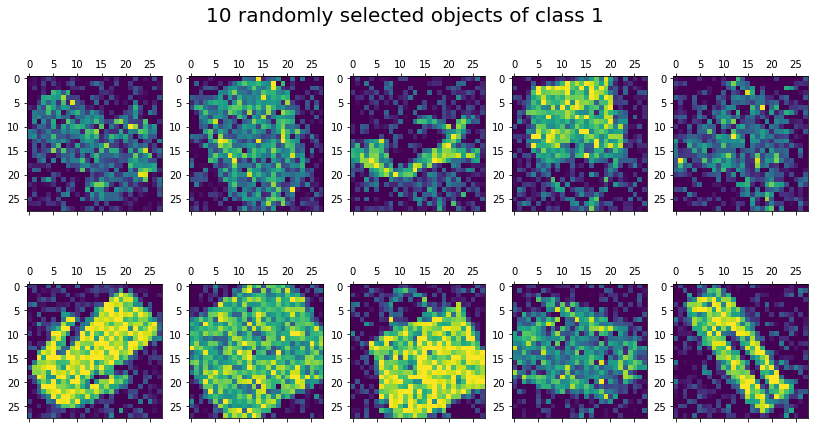

In [89]:
# Plotting
plt.rcParams['figure.figsize'] = [14, 7]
fig, axs = plt.subplots(2, 5)
fig.suptitle('10 randomly selected objects of class 1',fontsize=20)
axs[0, 0].matshow(matrixpos[0])
axs[0, 1].matshow(matrixpos[1])
axs[0, 2].matshow(matrixpos[2])
axs[0, 3].matshow(matrixpos[3])
axs[0, 4].matshow(matrixpos[4])
axs[1, 0].matshow(matrixpos[5])
axs[1, 1].matshow(matrixpos[6])
axs[1, 2].matshow(matrixpos[7])
axs[1, 3].matshow(matrixpos[8])
axs[1, 4].matshow(matrixpos[9])
plt.show()

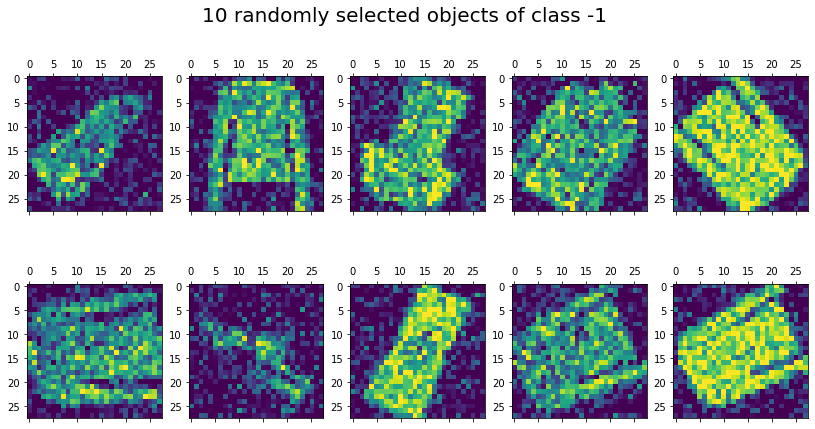

In [90]:
# Plotting
plt.rcParams['figure.figsize'] = [14, 7]
fig, axs = plt.subplots(2, 5)
fig.suptitle('10 randomly selected objects of class -1',fontsize=20)
axs[0, 0].matshow(matrixneg[0])
axs[0, 1].matshow(matrixneg[1])
axs[0, 2].matshow(matrixneg[2])
axs[0, 3].matshow(matrixneg[3])
axs[0, 4].matshow(matrixneg[4])
axs[1, 0].matshow(matrixneg[5])
axs[1, 1].matshow(matrixneg[6])
axs[1, 2].matshow(matrixneg[7])
axs[1, 3].matshow(matrixneg[8])
axs[1, 4].matshow(matrixneg[9])
plt.show()

### ii.

Checking the class sizes.

In [82]:
np.unique(ytrain, return_counts=True)

(array([-1.,  1.]), array([ 882, 2118], dtype=int64))

There are 882 negative objects and 2118 positive objects in the trainin set. This means that our data set is unbalanced.

### iii.

Now we consider possible performance metrics.

We cannot use accuracy as the assumption of the data set being balanced is not met  - more than 70% of the training data is of positive class, thus simply classifying an object as positive should yield at least 70% accuracy even though this classifier is not robust. Hence, if we use accuracy, we might have a biased understanding of how well the classifier is performing.

Using AUC-ROC may cause problems as well because the data is imbalanced. As we have a large number of true positives (since we have significantly more objects of a positive class), the true positive rate is increased, and so TPR vs FPR curve would be affected in a biased way.

Precision and recall would both be affected similarly by the difference of class probabilities thus leading to the least biased metric for this example. If we assume that our testing data has similar class imbalance, this is a better metric to use as AUC-PR is good for unbalanced sets.

### iv.

A random classifier always has accuracy $\frac{1}{2}$. Observe that 

$$accuracy = \mathbb{P}\big(class = 1\big) \cdot \mathbb{P}\big(prediction = 1\big) + \mathbb{P}\big(class = 0\big) \cdot \mathbb{P}\big(prediction = 0\big)$$

and a random classifier has $\mathbb{P}\big(prediction = 1\big)=\mathbb{P}\big(prediction = 0\big)=\frac{1}{2}$ we can simplify this as

$$accuracy = \mathbb{P}\big(class = 1\big) \cdot \frac{1}{2} + \mathbb{P}\big(class = 0\big) \cdot \frac{1}{2}$$

and as the classifier is binary we also have $\mathbb{P}\big(class = 1\big)+\mathbb{P}\big(class = 0\big)=1$ yielding that over both the training and test data sets the accuracy is $\frac{1}{2}$.

### v.

Observe that

$$
TPR = \frac{TP}{FN+TP} = \frac{\mathbb{P}\big(class = 1\big) \cdot \mathbb{P}\big(prediction = 1\big)}{\mathbb{P}\big(class = 1\big) \cdot \mathbb{P}\big(prediction = 0\big)+\mathbb{P}\big(class = 1\big) \cdot \mathbb{P}\big(prediction = 1\big)}
$$

which, since a random classifier has $\mathbb{P}\big(prediction = 1\big)=\mathbb{P}\big(prediction = 0\big)=\frac{1}{2}$ we can rewrite as

$$
TPR = \frac{\mathbb{P}\big(class = 1\big) \cdot \frac{1}{2}}{\mathbb{P}\big(class = 1\big) \cdot \frac{1}{2} + \mathbb{P}\big(class = 1\big) \cdot \frac{1}{2}} = \frac{\mathbb{P}\big(class = 1\big)}{\mathbb{P}\big(class = 1\big)+ \mathbb{P}\big(class = 1\big)} = \frac{1}{2}.
$$

And similarly

$$
FPR = \frac{FP}{TN+FP} = \frac{\mathbb{P}\big(class = 0\big) \cdot \mathbb{P}\big(prediction = 1\big)}{\mathbb{P}\big(class = 0\big) \cdot \mathbb{P}\big(prediction = 0\big)+\mathbb{P}\big(class = 0\big) \cdot \mathbb{P}\big(prediction = 1\big)}
$$

can be rewritten as

$$
FPR = \frac{\mathbb{P}\big(class = 0\big) \cdot \frac{1}{2}}{\mathbb{P}\big(class = 0\big)\cdot \frac{1}{2} +\mathbb{P}\big(class = 0\big)\cdot \frac{1}{2}} = \frac{\mathbb{P}\big(class = 0\big)}{\mathbb{P}\big(class = 0\big)+ \mathbb{P}\big(class = 0\big)} = \frac{1}{2}.
$$

Hence the ratio between TPR and FPR is always 1, and so the ROC curve will be y = x thus implying that AUC-ROC is $\frac{1}{2}$, i.e. the area of a right isosceles triangle with side length 1.

Note that $$ Recall = TPR = \frac{1}{2} $$ and that

$$
Precision  = \frac{TP}{FP+TP} = \frac{\mathbb{P}\big(class = 1\big) \cdot \mathbb{P}\big(prediction = 1\big)}{\mathbb{P}\big(class = 0\big) \cdot \mathbb{P}\big(prediction = 1\big)+\mathbb{P}\big(class = 1\big) \cdot \mathbb{P}\big(prediction = 1\big)}
$$

which, as before, can be rewritten as

$$
Precision = \frac{\mathbb{P}\big(class = 1\big) \cdot \frac{1}{2}}{\mathbb{P}\big(class = 0\big) \cdot \frac{1}{2} +\mathbb{P}\big(class = 1\big) \cdot \frac{1}{2}} = \frac{\mathbb{P}\big(class = 1\big)}{\mathbb{P}\big(class = 0\big) + \mathbb{P}\big(class = 1\big)} 
$$

and as the classifier is binary we also have $\mathbb{P}\big(class = 1\big)+\mathbb{P}\big(class = 0\big)=1$ yielding that $ Precision = \mathbb{P}\big(class = 1\big)$.

Hence the ratio between precision and recall is always constant and so AUC-PR is equal to the size of the positive class $\mathbb{P}\big(class = 1\big)$, which is $0.706$ for the training data and unknown (but presumably similar) for the testing data.

## Q2

First we will define some functions.

<strong>pr_auc_score</strong>

    Input: y_true, y_prob_pred
    Output: auc_pr

The function, given an array of true labels and an array of prediction probabilities for the labels, computes and returns AUC-PR score. The AUC-PR score is our preferred metric to use for comparing different classifiers.

<strong>stratclf</strong>

    Input: classifier, Xtrain_data, Ytrain_data
    Output: acc, roc, pr

The function, given a classifier (such as KNN), and training data performs a 5-fold stratified cross validation over the training data using a given classifier and returns accuracy, AUC-ROC and AUC-PR scores for each fold.

In [8]:
def pr_auc_score(y_true, y_prob_pred):
    """
    Generates the Area Under the Curve for Precision and Recall.
    """
    # Getting the PR curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob_pred)
    
    # Getting the area under the curve
    auc_pr = auc(recall, precision)
    
    return auc_pr

# Making a scorer to be used for grid search
pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True, needs_proba=True)



def stratclf(classifier,Xtrain_data,Ytrain_data):
    """
    Computes accuracy, AUC-ROC and AUC-PR for each of 5 folds of stratified cross validation of a given classifier.
    """
    # Getting stratified splitting of the training data
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(Xtrain_data, Ytrain_data)
    
    # Initialising vectors to store scores
    acc = np.zeros(5)
    roc = np.zeros(5)
    pr = np.zeros(5)
    
    # Initialising a counter to be used in a for loop
    count = 0
    
    # Performing 5-fold cross validation
    for train_index, test_index in skf.split(Xtrain_data, Ytrain_data):
        
        # Splitting the data into training and tests sets
        X_train, X_test = Xtrain_data[train_index], Xtrain_data[test_index]
        y_train, y_test = Ytrain_data[train_index], Ytrain_data[test_index]
        
        # Fitting the classifier
        clf = classifier
        clf.fit(X_train, y_train)
        
        # Making predictions
        y_pred = clf.predict(X_test)
        y_prob_pred = clf.predict_proba(X_test)
        y_prob_pred = y_prob_pred[:, 1]
        
        # Computing relevant scores
        acc[count] =  accuracy_score(y_test, y_pred)
        roc[count] =  roc_auc_score(y_test, y_pred)
        pr[count] =  pr_auc_score(y_test, y_prob_pred)
        count += 1

    return acc, roc, pr

Now we can perform the 5-fold stratified cross-validation over the training data set using the k=1 Nearest Neighbour classifier.

### i. 

In [9]:
# Initialising k = 1 nearest neigbour 
k=1

# Calling the function and getting the scores for each fold
acc,roc,pr = stratclf(KNeighborsClassifier(n_neighbors=k),xtrain,ytrain)

# Formatting a table to print the results
table = {'':['1st Fold','2nd Fold','3rd Fold','4th Fold','5th Fold'], 'Accuracy': acc.tolist(), 'AUC-ROC': roc.tolist(), 
          'AUC-PR': pr.tolist()}

df_folds = pd.DataFrame(table)
df_folds = df_folds.set_index('')

df_folds.T

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold
Accuracy,0.740000,0.760000,0.740000,0.738333,0.755000
AUC-ROC,0.708030,0.732151,0.713015,0.712566,0.729314
AUC-PR,0.886864,0.896477,0.888403,0.887386,0.894441


The table above shows the computed required scores.

### ii.

We will use the results of the previous part to get the mean and stadard deviation of each performance metric accross all folds.

In [10]:
# Computing the means and standard deviations
metrics_orig = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Formatting a table to print the results
table = {'Metric':  ['Mean Accuracy', 'Std Accuracy', 'Mean AUC-ROC', 'Std AUC-ROC','Mean AUC-PR', 'Std AUC-PR'],
        'Scores': metrics_orig
        }

df = pd.DataFrame(table)
df = df.set_index('Metric')

# Printing the results
df

,Scores
Metric,
Mean Accuracy,0.746667
Std Accuracy,0.009006
Mean AUC-ROC,0.719015
Std AUC-ROC,0.009766
Mean AUC-PR,0.890714
Std AUC-PR,0.003958


As we can see from the table above the classifier has a pretty high average AUC-PR score.

### iii.

We will use different types of pre-processing: Standard Scaler, MinMax Scaler and Quantile Scaler. As our objects are 'flattened' pictures, each 'feature' should be similarly important and scaling might not be necessary.

####  1. Standard Scaler

In [11]:
# Scaling the data
std_scaler = preprocessing.StandardScaler()
xtrain_std = std_scaler.fit(xtrain).transform(xtrain)

# Initialising k = 1 nearest neigbour 
k=1

# Obtaining scores using the classifier
acc,roc,pr = stratclf(KNeighborsClassifier(n_neighbors=k),xtrain_std,ytrain)

In [12]:
# Formatting a table of scores
table = {'':['1st Fold','2nd Fold','3rd Fold','4th Fold','5th Fold'], 'Accuracy': acc.tolist(), 'AUC-ROC': roc.tolist(), 
          'AUC-PR': pr.tolist()}

df_folds = pd.DataFrame(table)
df_folds = df_folds.set_index('')

# Printing the results
df_folds.T

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold
Accuracy,0.731667,0.760000,0.760000,0.740000,0.733333
AUC-ROC,0.697148,0.728827,0.727166,0.703891,0.699163
AUC-PR,0.882617,0.895419,0.894903,0.884947,0.882707


In [13]:
# Saving the results for future comparisons
metrics_std = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

#### 2. Minmax

In [14]:
# Scaling the data
minmax_scaler = preprocessing.MinMaxScaler()
xtrain_minmax = minmax_scaler.fit(xtrain).transform(xtrain)

# Initialising k = 1 nearest neigbour
k=1

# Obtaining scores using the classifier
acc,roc,pr = stratclf(KNeighborsClassifier(n_neighbors=k),xtrain_minmax,ytrain)

In [15]:
# Formatting a table of scores
table = {'':['1st Fold','2nd Fold','3rd Fold','4th Fold','5th Fold'], 'Accuracy': acc.tolist(), 'AUC-ROC': roc.tolist(), 
          'AUC-PR': pr.tolist()}

df_folds = pd.DataFrame(table)
df_folds = df_folds.set_index('')

# Printing the results
df_folds.T

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold
Accuracy,0.740000,0.756667,0.745000,0.741667,0.753333
AUC-ROC,0.704706,0.726469,0.714891,0.713287,0.724847
AUC-PR,0.885881,0.894347,0.889523,0.887970,0.892837


In [16]:
# Saving the results for future comparisons
metrics_minmax = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

#### 3. Quantile transform

In [17]:
# Scaling the data
quantile_scaler = preprocessing.QuantileTransformer(random_state=0)
xtrain_quantile = quantile_scaler.fit_transform(xtrain)

# Initialising k = 1 nearest neigbour
k=1

# Obtaining scores using the classifier
acc,roc,pr = stratclf(KNeighborsClassifier(n_neighbors=k),xtrain_quantile,ytrain)

In [18]:
# Formatting a table of scores
table = {'':['1st Fold','2nd Fold','3rd Fold','4th Fold','5th Fold'], 'Accuracy': acc.tolist(), 'AUC-ROC': roc.tolist(), 
          'AUC-PR': pr.tolist()}

df_folds = pd.DataFrame(table)
df_folds = df_folds.set_index('')

# Printing the results
df_folds.T

,1st Fold,2nd Fold,3rd Fold,4th Fold,5th Fold
Accuracy,0.675000,0.715000,0.713333,0.731667,0.770000
AUC-ROC,0.630467,0.682033,0.679192,0.694695,0.736667
AUC-PR,0.855810,0.876004,0.874961,0.881204,0.898212


In [19]:
# Saving the results for future comparisons
metrics_quantile = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

#### Summary

Now we can summarize all scores in one table. Below you can see means and standard deviations of Accuracy, AUC-ROC and AUC-PR of 5-fold stratified cross-validation using k=1 nearest neighbour classifier on unscaled data, data scaled using standard, minmax and quantile scalers.

In [20]:
df = df.rename(columns={'Scores': 'Unscaled'})
df['Standard Scaler'] = metrics_std
df['MinMax Scaler'] = metrics_minmax
df['Quantile Scaler'] = metrics_quantile
df

,Unscaled,Standard Scaler,MinMax Scaler,Quantile Scaler
Metric,,,,
Mean Accuracy,0.746667,0.745000,0.747333,0.721000
Std Accuracy,0.009006,0.012561,0.006549,0.030743
Mean AUC-ROC,0.719015,0.711239,0.716840,0.684611
Std AUC-ROC,0.009766,0.013866,0.008006,0.033997
Mean AUC-PR,0.890714,0.888118,0.890112,0.877238
Std AUC-PR,0.003958,0.005813,0.003105,0.013575


We can see accuracy improving after preprocessing, AUC-ROC decreasing after preprocessing and AUC-PR, our preferred metric when comparing classifiers, is not impacted much by preprocessing. Since AUC-PR is the metric we will use, we shall note that the scores are slighly bettter with Standard Scaler and MinMax Scaler even though standard deviation is slightly increased for the Standard Scaler. Quantile Scaler does not seem good for our data. As we will mostly look at AUC-PR scores and the difference between scores for scaled and unscaled data is small, in the future we will try each classifier with both scaled and unscaled data. 

### iv.

In this part we will use NON stratified cross-validation as it was not specified that we should use the stratified one. To find an optimal k for the K-Nearest Neighbour classifier we will first develop a function **CVKNN** analogous to previously used **stratclf** which performs 5-fold (nonstratified) cross validation over the training data using KNN classifier with a specified k and returns accuracy, AUC-ROC and AUC-PR for each fold.

In [21]:
def CVKNN(k,Xtrain_data,Ytrain_data):
    """
    Computes accuracy, AUC-ROC and AUC-PR for each of 5 folds of cross-validation of KNN classifier with a given k
    """
    # Initialising vectors to store scores for each fold
    acc = np.zeros(5)
    roc = np.zeros(5)
    pr = np.zeros(5)
    
    # Getting 5 splits for the cross-validation
    kf = KFold(n_splits=5)
    kf.get_n_splits(Xtrain_data)
    
    # Initialising a counter to be used in a for loop
    count = 0
    
    # Performing 5-fold cross validation
    for train_index, test_index in kf.split(Xtrain_data):
        
        # Splitting the data intom training and testing sets
        X_train, X_test = Xtrain_data[train_index], Xtrain_data[test_index]
        y_train, y_test = Ytrain_data[train_index], Ytrain_data[test_index]
        
        # Fitting the KNN classifier with a given k
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(X_train, y_train)
        
        # Making predictions
        y_pred = neigh.predict(X_test)
        y_prob_pred = neigh.predict_proba(X_test)
        y_prob_pred = y_prob_pred[:, 1]
        
        # Getting scores for each fold
        acc[count] =  accuracy_score(y_test, y_pred)
        roc[count] =  roc_auc_score(y_test, y_pred)
        pr[count] =  pr_auc_score(y_test, y_prob_pred)
        count += 1

    return acc, roc, pr

Now that we have a function we will go over 1 through 20 possible k values for the KNN classifier.

In [22]:
# Setting initial values
max_k = 20 # The maximum number of neighbours we will go over
meanacc = np.zeros(max_k) # Initialising a zero vector to store mean Accuracy score of 5-fold stratified CV for each k
stdacc = np.zeros(max_k) # Initialising a zero vector to store std of Accuracy score of 5-fold stratified CV for each k
meanroc = np.zeros(max_k) # Initialising a zero vector to store mean AUC-ROC score of 5-fold stratified CV for each k
stdroc = np.zeros(max_k) # Initialising a zero vector to store std of AUC-ROC score of 5-fold stratified CV for each k
meanpr = np.zeros(max_k) # Initialising a zero vector to store mean AUC-PR score of 5-fold stratified CV for each k
stdpr = np.zeros(max_k) # Initialising a zero vector to store std of AUC-PR score of 5-fold stratified CV for each k
k_vec = np.linspace(1,max_k,max_k) # Initialising a vector of indices to be used for plotting

# Going over k from 1 to max_k (included) to compute the scores, their means and standard deviations for each k
for k in range(1,max_k+1):
    acc, roc, pr = CVKNN(k, xtrain, ytrain)
    meanacc[k-1] = np.mean(acc)
    stdacc[k-1] = np.std(acc)
    meanroc[k-1] = np.mean(roc)
    stdroc[k-1] = np.std(roc)
    meanpr[k-1] = np.mean(pr)
    stdpr[k-1] = np.std(pr)

As our preferred metric is AUC-PR we will now plot means of AUC-PR scores for each k including (light blue fill) their means of standard deviations.

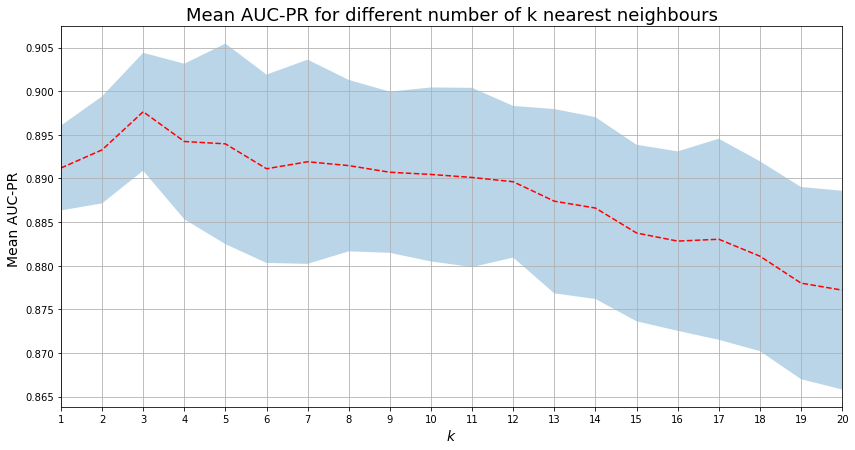

In [23]:
# Plotting
plt.plot(k_vec,meanpr, 'r--')
plt.fill_between(k_vec,meanpr-stdpr,meanpr+stdpr,alpha = 0.3)   
plt.xlim([1,max_k])
plt.xticks(k_vec)
plt.xlabel(r'$k$',fontsize = 14)
plt.ylabel(r'Mean AUC-PR ',fontsize = 14)
plt.title(r'Mean AUC-PR for different number of k nearest neighbours',fontsize = 18)
plt.grid()
plt.show()

Clearly the optimal parameter value is k = 3 for the KNN classifier as with this value we have the highest mean AUC-PR score and the standard deviation is relatively small. The cross-validation accuracy, AUC-ROC and AUC-PR can be seen below.

In [24]:
# Initialising the optimal parameter value
bestk = 3
print('The mean accuracy of the cross-validation of KNN with k=3 is', meanacc[bestk-1])
print('The mean AUC-ROC of the cross-validation of KNN with k=3 is', meanroc[bestk-1])
print('The mean AUC-PR of the cross-validation of KNN with k=3 is', meanpr[bestk-1])

The mean accuracy of the cross-validation of KNN with k=3 is 0.7603333333333333
The mean AUC-ROC of the cross-validation of KNN with k=3 is 0.714832234727953
The mean AUC-PR of the cross-validation of KNN with k=3 is 0.8976387905874017


## Q3

In this section we will go over K-Nearest Neighbours Classifier, Perceptron, Naïve Bayes Classifier, Logistic Regression,
Linear SVM and Kernelized SVM. We will tune the hyperparameters and we will pick best performing classifiers using AUC-PR metric, as we have earlier decided that this is the best metric for our problem.

### KNN

As before we will try to find the best k for K-Nearest Neighbours classifier. We are performing almost identical procedure as earlier, but this time we are using stratified cross validation. We expect the same results. As the metrics are almost the same for scaled and unscaled data (seen before), and we have obtained slightly better scores with unscaled data, for this classifier we will not scale the data.

In [25]:
# Setting initial values
max_k = 20 # The maximum number of neighbours we will go over
meanpr = np.zeros(max_k) # Initialising a zero vector to store mean AUC-PR score of 5-fold stratified CV for each k
stdpr = np.zeros(max_k) # Initialising a zero vector to store std of AUC-PR score of 5-fold stratified CV for each k
k_vec = np.linspace(1,max_k,max_k) # Initialising a vector of indices to be used for plotting

# Going over k from 1 to max_k (included) to compute AUC-PR scores, their mean and standard deviation for each k
for k in range(1,max_k+1):
    __, __, pr = stratclf(KNeighborsClassifier(n_neighbors=k), xtrain, ytrain)
    meanpr[k-1] = np.mean(pr)
    stdpr[k-1] = np.std(pr)

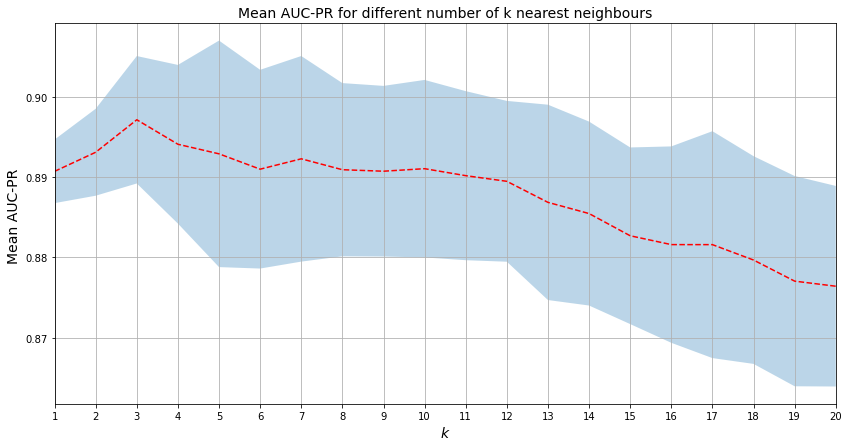

In [26]:
# Plotting mean AUC-PR for each k

plt.plot(k_vec, meanpr, 'r--')
plt.fill_between(k_vec, meanpr-stdpr, meanpr+stdpr, alpha = 0.3) # Including a fill with standard deviation  
plt.xlim([1,max_k])
plt.xticks(k_vec)
plt.xlabel(r'$k$',fontsize = 14)
plt.ylabel(r'Mean AUC-PR ',fontsize = 14)
plt.title(r'Mean AUC-PR for different number of k nearest neighbours',fontsize = 14)
plt.grid()
plt.show()

Using the previously chosen best metric for this problem (AUC-PR), from the plot above we can deduce that k = 3 is the best parameter for this classifier. We could also consider k = 1 as even though it, on average, has slightly worse AUC-PR score, it also has smaller standard deviation. But k = 3 is a more reasonable option as looking at only 1 neighbour is not good enough when generalizing to unseen data. We will not check values of k > 20 as we already see a clear pattern of the AUC-PR score decreasing with larger k values.

We will now obtain scores for the best KNN classifier for this problem. 

In [27]:
# Getting the classifier: KNN with k=3 on unscaled data
acc, roc, pr = stratclf(KNeighborsClassifier(n_neighbors=3), xtrain, ytrain)

# Obtaining the relevant metrics 
metrics_knn = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Setting up a table for comparison with other future classifiers
table_best = {'Metric':  ['Mean Accuracy', 'Std Accuracy', 'Mean AUC-ROC', 'Std AUC-ROC','Mean AUC-PR', 'Std AUC-PR'],
        'KNN': metrics_knn}

df_best = pd.DataFrame(table_best)
df_best = df_best.set_index('Metric')

# Showing the results
df_best

,KNN
Metric,
Mean Accuracy,0.759333
Std Accuracy,0.004422
Mean AUC-ROC,0.713749
Std AUC-ROC,0.009117
Mean AUC-PR,0.897141
Std AUC-PR,0.007937


### Perceptron

We will now try to identify the best Perceptron classifier for our problem. We will perform a grid search over parameters penalty (regularization term), alpha (scaler of the regularization term), and eta0 (learning rate). The following code part is commented out as it takes a while to run it.

So our best parameters for both scaled and unscaled data are and penalty = None, alpha = 0, eta0 = 1e-03. Since the regularization term is not applied, we can leave alpha as default (not being used). We will now perform this classifier on both scaled and unscaled data.

In [28]:
# Creating a calibrated classifier (as otherwise we cannot obtain AUC-PR scores)
clf = CalibratedClassifierCV(Perceptron(eta0 = 0.001, random_state=0))

# Performing classification on unscaled data
acc, roc, pr =stratclf(clf, xtrain, ytrain)

# Obtaining relevant metrics
metrics_p = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Performing classification on scaled data (using std)
acc, roc, pr = stratclf(clf, xtrain_std, ytrain)

# Obtaining relevant metrics
metrics_p_std = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Performing classification on scaled data (using minmax)
acc, roc, pr = stratclf(clf, xtrain_minmax, ytrain)

# Obtaining relevant metrics
metrics_p_minmax = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Creating a table to compare the metrics
table_p = {'Metric':  ['Mean Accuracy', 'Std Accuracy', 'Mean AUC-ROC', 'Std AUC-ROC','Mean AUC-PR', 'Std AUC-PR'],
        'Perceptron': metrics_p, 'Perceptron std': metrics_p_std, 'Perceptron minmax': metrics_p_minmax}
df_p = pd.DataFrame(table_p)
df_p = df_p.set_index('Metric')

# Printing the table
df_p

,Perceptron,Perceptron std,Perceptron minmax
Metric,,,
Mean Accuracy,0.706000,0.706000,0.706000
Std Accuracy,0.000816,0.000816,0.000816
Mean AUC-ROC,0.500000,0.500000,0.500000
Std AUC-ROC,0.000000,0.000000,0.000000
Mean AUC-PR,0.853000,0.743865,0.746805
Std AUC-PR,0.000408,0.014098,0.015051


We can see a significant difference between Perceptron used on scaled and unscaled data (observe the relevant rows of Mean AUC-PR and Std AUC-PR). Thus our best Perceptron classifier is calibrated with eta0 = 0.001 and default parameters on unscaled data.

In [29]:
# Adding relevant metrics to the comparison of classifiers table
df_best['Perceptron'] = metrics_p

### Naïve Bayes

Naïve Bayes does not have many parameters to tune and we have checked that changing prior to class probabilities does not have any impact. The only Naïve Bayes classifier applicable to this problem are Gaussian Naïve Bayes and Bernoulli Naïve Bayes. So we only need to pick one of the two and check how they perform on scaled and unscaled data.

In [30]:
# Gaussian Naive Bayes on unscaled data
acc, roc, pr = stratclf(GaussianNB(),xtrain,ytrain)

# Obtaining relevant metrics
metrics_GNB = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Gaussian Naive Bayes on scaled data (standard scaler)
acc, roc, pr = stratclf(GaussianNB(),xtrain_std,ytrain)

# Obtaining relevant metrics
metrics_GNB_std = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Gaussian Naive Bayes on scaled data (minmax scaler)
acc, roc, pr = stratclf(GaussianNB(),xtrain_minmax,ytrain)

# Obtaining relevant metrics
metrics_GNB_minmax = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

In [31]:
# Bernoulli Naive Bayes on unscaled data
acc, roc, pr = stratclf(BernoulliNB(),xtrain,ytrain)

# Obtaining relevant metrics
metrics_BNB = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Bernoulli Naive Bayes on scaled data (standard scaler)
acc, roc, pr = stratclf(BernoulliNB(),xtrain_std,ytrain)

# Obtaining relevant metrics
metrics_BNB_std = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Bernoulli Naive Bayes on scaled data (minmax scaler)
acc, roc, pr = stratclf(BernoulliNB(),xtrain_minmax,ytrain)

# Obtaining relevant metrics
metrics_BNB_minmax = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

In [32]:
# Setting up a table of metrics of Naive Bayes classifiers
tableNB = {'Metric':  ['Mean Accuracy', 'Std Accuracy', 'Mean AUC-ROC', 'Std AUC-ROC','Mean AUC-PR', 'Std AUC-PR'],
        'Gaussian NB': metrics_GNB, 'Gaussian NB std': metrics_GNB_std, 'Gaussian NB minmax': metrics_GNB_minmax,
        'Bernoulli NB': metrics_BNB, 'Bernoulli NB std': metrics_BNB_std, 'Bernoulli NB minmax': metrics_BNB_minmax}

df_NB= pd.DataFrame(tableNB)
df_NB = df_NB.set_index('Metric')
print(df_NB)

               Gaussian NB  Gaussian NB std  Gaussian NB minmax  Bernoulli NB  \
Metric                                                                          
Mean Accuracy     0.552333         0.552333            0.552333      0.555000   
Std Accuracy      0.036947         0.036947            0.036947      0.017512   
Mean AUC-ROC      0.543998         0.543998            0.543998      0.556167   
Std AUC-ROC       0.034463         0.034463            0.034463      0.015169   
Mean AUC-PR       0.768171         0.767580            0.767394      0.779584   
Std AUC-PR        0.032840         0.033278            0.032832      0.019056   

               Bernoulli NB std  Bernoulli NB minmax  
Metric                                                
Mean Accuracy          0.529333             0.555000  
Std Accuracy           0.035988             0.017512  
Mean AUC-ROC           0.499575             0.556167  
Std AUC-ROC            0.031489             0.015169  
Mean AUC-PR          

From the metrics above we can see that BernoulliNB is clearly a superior classifier. As the scores are the same for both preprocessed (using minmax) data and unscaled data, for better generalization to unseeen data we will consider Bernoulli Naïve Bayes on scaled (minmax) data as the best Naïve Bayes classifier.

In [33]:
# Adding relevant metrics to the comparison of classifiers table
df_best['Naive Bayes'] = metrics_BNB_minmax

### Logistic regression

We will perform a grid search through parameters solver (algorithm to use in the optimization problem), penalty (the norm of the penalty, if applied) and different values of the inverse of regularization strength C. We will also check what is the best preprocessing method using this classifier. The grid search part of the code is commented out as it takes a while to run.

In [34]:
# Setting up parameter values that we want to check
grid_param = {'penalty': ['l1', 'l2', 'elasticnet', None],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
             }
# Defining the grid search
gd_sr = GridSearchCV(estimator=LogisticRegression(),
                     param_grid=grid_param,
                     scoring=pr_auc_scorer,
                     cv=StratifiedKFold(n_splits=5),
                     n_jobs=-1)

# Performing the grid search on unscaled data
#gd_sr.fit(xtrain, ytrain)
#print(gd_sr.best_params_)

# Performing the grid search on scaled data using std scaler
gd_sr.fit(xtrain_std, ytrain)
print(gd_sr.best_params_)

# Performing the grid search on scaled data using minmax scaler
#gd_sr.fit(xtrain_minmax, ytrain)
#print(gd_sr.best_params_)

C:\Users\gabij\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.853      0.76689567 0.76688457
 0.76693023 0.76688789        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.79322572 0.75500085 0.75501017 0.75499165 0.75500064
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.75082269
 0.7453101  0.74527113 0.74525562 0.74566052        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.74463263 0.74233761 0.74244568
 0.74248648 0.74412833        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.74415103 0.74191775 0.74231958 0.74245882 0.74399659
        nan        nan        nan        nan        n

{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}


We have found that for both scaled and unscaled data the best parameters (i.e. returning highest AUC-PR scores) for Logistic Regression are 'saga' for solves, 'l1' for penalty and C=0.001. Now we will cobtain relevant metrics of the performance of Logistic Regression with these parameters.

In [35]:
# Logistic regression on unscaled data
acc, roc, pr = stratclf(LogisticRegression(random_state=0, C=0.001, penalty = 'l1', solver = 'saga', max_iter=1000), 
                        xtrain, ytrain)

# Obtaining relevant metrics
metrics_LR = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Logistic regression on scaled (std) data
acc, roc, pr = stratclf(LogisticRegression(random_state=0, C=0.001, penalty = 'l1', solver = 'saga', max_iter=1000), 
                        xtrain_std, ytrain)

# Obtaining relevant metrics
metrics_LR_std = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Logistic regression on scaled (minmax) data
acc, roc, pr = stratclf(LogisticRegression(random_state=0, C=0.001, penalty = 'l1', solver = 'saga', max_iter=1000), 
                        xtrain_minmax, ytrain)

# Obtaining relevant metrics
metrics_LR_minmax = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

In [36]:
# Setting up a table of metrics
tableLR= {'Metric':  ['Mean Accuracy', 'Std Accuracy', 'Mean AUC-ROC', 'Std AUC-ROC','Mean AUC-PR', 'Std AUC-PR'],
        'LR': metrics_LR, 'LR std': metrics_LR_std, 'LR minmax': metrics_LR_minmax}

df_LR = pd.DataFrame(tableLR)
df_LR = df_LR.set_index('Metric')
print(df_LR)

                     LR    LR std  LR minmax
Metric                                      
Mean Accuracy  0.691667  0.706000   0.706000
Std Accuracy   0.015348  0.000816   0.000816
Mean AUC-ROC   0.529866  0.500000   0.500000
Std AUC-ROC    0.018882  0.000000   0.000000
Mean AUC-PR    0.753335  0.853000   0.853000
Std AUC-PR     0.015442  0.000408   0.000408


From the table above we can deduce that the best Logistic Regression is with parameters 'saga' for solver, 'l1' for penalty and C=0.001 on scaled data and for convenience we will use the standard scaler.

In [37]:
# Adding relevant metrics to the comparison of classifiers table
df_best['Logistic Regression'] = metrics_LR_std

### Linear SVM 

For linear SVM the only parameter to tune is the regularization parameter C. So we need to find C with which the Linear SVM classifier has the highest AUC-PR scores. We have checked (code omitted for running time saving purposes) that Linear SVM for this problem works best with scaled data (minmax scaler) so this is what we will use. The next part of the code is commented out as it takes a while to run it.

In [ ]:
# Setting initial value
param = [1e-04, 1e-03, 0.01, 0.1, 1, 10, 100, 1000] # Values of parameter C that we want to check for the Logistic Regression
max_k = np.shape(param)[0] # Number of values of parameter C that we want to check for the Logistic Regression
meanpr = np.zeros(max_k) # Initialising a zero vector to store mean AUC-PR score of 5-fold stratified CV for each k
stdpr = np.zeros(max_k) # Initialising a zero vector to store std of AUC-PR score of 5-fold stratified CV for each k
k_vec = np.linspace(1,max_k,max_k) # Initialising a vector of indices to be used for plotting
count = 0 # Initialising a counter used in a for loop

# Computing AUC-PR scores, their mean and standard deviation for Linear SVM with different values of C
for k in param:
    clf = CalibratedClassifierCV(LinearSVC(C=k, random_state=0, max_iter=1000, tol=1e-03))
    __, __, pr = stratclf(clf,xtrain_minmax,ytrain)
    meanpr[count] = np.mean(pr)
    stdpr[count] = np.std(pr)
    count += 1

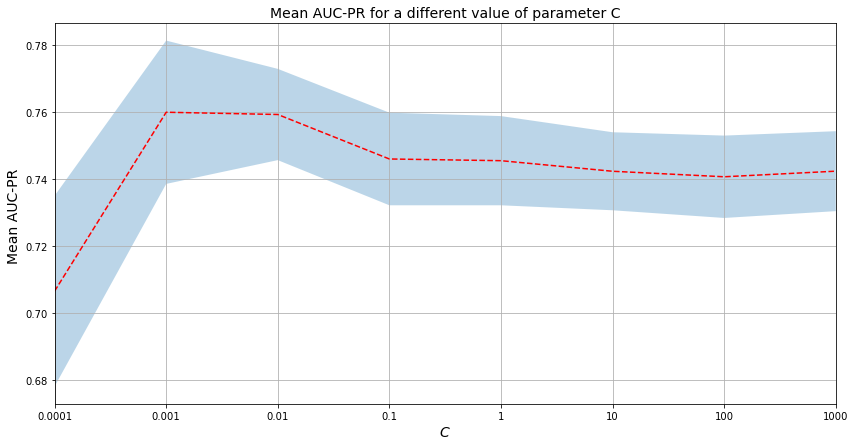

In [39]:
# Plotting
plt.plot(k_vec,meanpr, 'r--')
plt.fill_between(k_vec,meanpr-stdpr,meanpr+stdpr,alpha = 0.3)   
plt.xlim([1,max_k])
plt.xticks(k_vec, param)
plt.xlabel(r'$C$',fontsize = 14)
plt.ylabel(r'Mean AUC-PR ',fontsize = 14)
plt.title(r'Mean AUC-PR for a different value of parameter C',fontsize = 14)
plt.grid()
plt.show()

So we pick the value C = 0.01 for Linear SVM classifier on scaled (minmax scaler) data as with C = 0.01 we have the highest AUC-PR with smaller standard deviation than with C=0.001. Now we run this classifier to obtain the relevant metrics. 

In [41]:
# Linear SVM on scaled (minmax) data with C=0.01; increased number of iterations for convergence
clf = CalibratedClassifierCV(LinearSVC(C=0.01, random_state=0, max_iter=100000))
acc, roc, pr = stratclf(clf, xtrain_minmax, ytrain)

# Obtaining relevant metrics
metrics_LSVM_minmax = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Adding relevant metrics to the comparison of classifiers table
df_best['Linear SVM'] = metrics_LSVM_minmax

print(df_best['Linear SVM'])

Metric
Mean Accuracy    0.705333
Std Accuracy     0.000667
Mean AUC-ROC     0.499528
Std AUC-ROC      0.000578
Mean AUC-PR      0.759134
Std AUC-PR       0.013625
Name: Linear SVM, dtype: float64


 ### Kernelized SVM

For the Kernelized SVM we will perform a grid search to find parameters that give us highest AUC-PR scores. We are tuning parameters kernel, gamma and the regularization parameter C. We have checked (code omitted for running time saving purposes) that Kernelized SVM for this problem works best with scaled data (standard scaler) so this is what we will use. The next coding part is commented out as it takes a while to run it.

The grid search suggests that the optimal parameters are: kernel = 'rbf', gamma = 1 and C = 0.01.

In [42]:
# Kernelized SVM on scaled (std) data with optimal parameters
acc, roc, pr = stratclf(SVC(C=0.01,gamma=1,kernel='rbf',random_state=0, tol=1e-3, probability=True),xtrain_std,ytrain)

# Obtaining the relevant metrics
metrics_KSVM_std = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

From the metrics above we can see that the Kernelized SVM with optimal parameters on scaled (standard scaler) data is clearly the superior classifier.

In [43]:
# Adding relevant metrics to the comparison of classifiers table
df_best['Kernelized SVM'] = metrics_KSVM_std
print(df_best['Kernelized SVM'])

Metric
Mean Accuracy    0.706000
Std Accuracy     0.000816
Mean AUC-ROC     0.500000
Std AUC-ROC      0.000000
Mean AUC-PR      0.861338
Std AUC-PR       0.001544
Name: Kernelized SVM, dtype: float64


#### Summary

We have found that for this problem the best classifiers are:

- KNN with k = 3 on unscaled data
- Perceptron with eta0 = 0.001 on unscaled data
- Naïve Bayes (Bernoulli) on data scaled with MinMax Scaler 
- Logistic Regression with solver = 'saga', penalty = 'l1' and C = 0.001 on data scaled with Standard Scaler
- Linear SVM with C = 0.01 on data scaled with MinMax Scaler
- Kernelized SVM with kernel = 'rbf', gamma = 1 and C = 0.01 on scaled data with Standard Scaler

And this is the summary table of the relevant metrics:

In [44]:
df_best

,KNN,Perceptron,Naive Bayes,Logistic Regression,Linear SVM,Kernelized SVM
Metric,,,,,,
Mean Accuracy,0.759333,0.706000,0.555000,0.706000,0.705333,0.706000
Std Accuracy,0.004422,0.000816,0.017512,0.000816,0.000667,0.000816
Mean AUC-ROC,0.713749,0.500000,0.556167,0.500000,0.499528,0.500000
Std AUC-ROC,0.009117,0.000000,0.015169,0.000000,0.000578,0.000000
Mean AUC-PR,0.897141,0.853000,0.779584,0.853000,0.759134,0.861338
Std AUC-PR,0.007937,0.000408,0.019056,0.000408,0.013625,0.001544


We can conclude that the best classifier (out of the ones we have tried) is KNN with k = 3 on unscaled data with highest AUC-PR score of around 0.897. We shall also note that Kernelized SVM classifier is almost as good and with much smaller standard deviation, thus we might prefer using it instead of K-Nearest Neighbours classifier.

## Q4

### i.

Reducing dimensionality using PCA and plotting a scatterplot of the training data of reduced dimensionality.

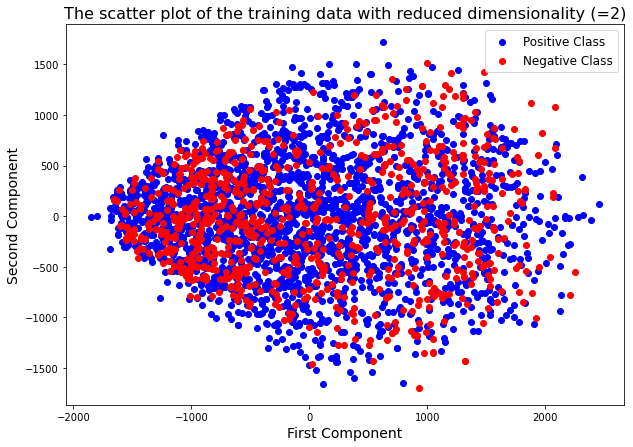

In [45]:
# Performing PCA on unscaled data
pca = PCA(n_components=2)
pca.fit(xtrain)
transformed = pca.transform(xtrain)

#recovered = pca.inverse_transform(transformed)

# Separating classes
idx_1 = np.where(ytrain == 1)
idx_0 = np.where(ytrain == -1)

# Making a scatter plot with objects from different classes plotted in different colors
plt.rcParams["figure.figsize"] = (10,7)
plt.scatter(transformed[idx_1].T[0], transformed[idx_1].T[1], c='b', marker="o", label='Positive Class')
plt.scatter(transformed[idx_0].T[0], transformed[idx_0].T[1], c='r', marker="o", label='Negative Class')
plt.legend(fontsize=12)
plt.ylabel('Second Component', fontsize=14)
plt.xlabel('First Component', fontsize=14)
plt.title('The scatter plot of the training data with reduced dimensionality (=2)', fontsize=16)
plt.show()

The first component is more variated, the second looks more centered, overall there is structure, but not much correlation between the components. The classes are not well separated between the first two components.

### ii.

We only do the scree plot of the first 15 components as plotting all the components produces a plot of poor clarity.

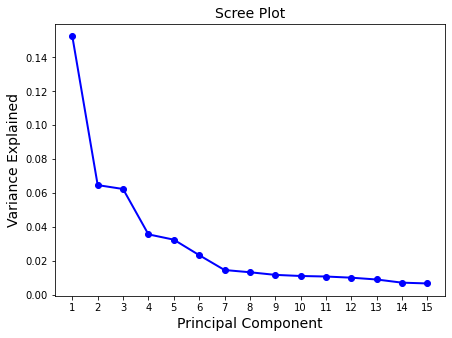

In [46]:
# Scree of the first 15 components
pca = PCA(n_components=15)
pca_fit = pca.fit(xtrain_std)

PC_values = np.arange(pca.n_components_) + 1

plt.rcParams["figure.figsize"] = (7,5)
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot', fontsize=14)
plt.xticks(np.linspace(1,15,15))
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Variance Explained', fontsize=14)
plt.show()

From the scree plot we can already see that it will take a lot of components to explain 95% of variance.

In [47]:
# Performing PCA with all possible components
pca = PCA(n_components=784)
pca_fit = pca.fit(xtrain_std)

# Finding the index of the component with which is at least 95% of the variance explained
opt = np.argwhere(np.cumsum(pca.explained_variance_ratio_)>=0.95)[0][0]

print('The number of dimensions that explain 95% variance in the training set is', opt+1)

The number of dimensions that explain 95% variance in the training set is 529


### iii.

So we reduce the number of dimensions of the data using PCA whilst keeping the dimensions that explain 95% of the variance. We will use our optimal classifier from the previous section (i.e. KNN) to obtain the optimal number k of nearest neighbours (tuning the hyperparameter) based on the AUC-PR metric over 5-fold stratified cross validated training data.

In [48]:
pca = PCA(n_components=opt+1)
pca.fit(xtrain)
transformed = pca.transform(xtrain)

In [49]:
# Setting initial values
max_k = 20 # The maximum number of neighbours we will go over
meanpr = np.zeros(max_k) # Initialising a zero vector to store mean AUC-PR score of 5-fold stratified CV for each k
stdpr = np.zeros(max_k) # Initialising a zero vector to store std of AUC-PR score of 5-fold stratified CV for each k
k_vec = np.linspace(1,max_k,max_k) # Initialising a vector of indices to be used for plotting

# Going over k from 1 to max_k (included) to compute AUC-PR scores, their mean and standard deviation for each k
for k in range(1,max_k+1):
    __, __, pr = stratclf(KNeighborsClassifier(n_neighbors=k), transformed, ytrain)
    meanpr[k-1] = np.mean(pr)
    stdpr[k-1] = np.std(pr)

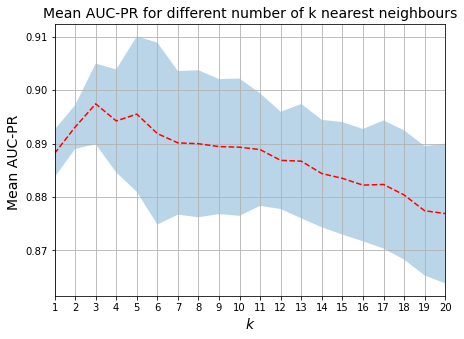

In [50]:
# Plotting mean AUC-PR for each k

plt.rcParams["figure.figsize"] = (7,5)
plt.plot(k_vec, meanpr, 'r--')
plt.fill_between(k_vec, meanpr-stdpr, meanpr+stdpr, alpha = 0.3) # Including a fill with standard deviation  
plt.xlim([1,max_k])
plt.xticks(k_vec)
plt.xlabel(r'$k$',fontsize = 14)
plt.ylabel(r'Mean AUC-PR ',fontsize = 14)
plt.title(r'Mean AUC-PR for different number of k nearest neighbours',fontsize = 14)
plt.grid()
plt.show()

Using the previously chosen best metric for this problem (AUC-PR), from the plot above we can deduce that k = 3 is the best parameter for this classifier on the transformed (using PCA) data. We will not check values of k > 20 as we already see a clear pattern of the AUC-PR score decreasing with larger k values. We will now obtain scores for this classifier.

In [51]:
# Getting the classifier: KNN with k=3 on transformed data
acc, roc, pr = stratclf(KNeighborsClassifier(n_neighbors=3), transformed, ytrain)

# Obtaining the relevant metrics 
metrics_knn_trans = list([np.mean(acc),np.std(acc),np.mean(roc),np.std(roc),np.mean(pr),np.std(pr)])

# Setting up a table for comparison with other future classifiers
table_PCA = {'Metric':  ['Mean Accuracy', 'StD Accuracy', 'Mean AUC-ROC', 'StD AUC-ROC','Mean AUC-PR', 'StD AUC-PR'],
        'KNN': metrics_knn_trans}

df_PCA = pd.DataFrame(table_PCA)
df_PCA = df_PCA.set_index('Metric')

# Showing the results
print (df_PCA)

df_best['KNN after PCA'] = metrics_knn_trans

                    KNN
Metric                 
Mean Accuracy  0.758667
StD Accuracy   0.002211
Mean AUC-ROC   0.715270
StD AUC-ROC    0.010090
Mean AUC-PR    0.897416
StD AUC-PR     0.007539


The KNN classifier with k = 3 on the training data transformed using PCA is performing almost exactly the same as our optimal classifier with the same characteristics on all original training data, see below:

In [52]:
df_best

,KNN,Perceptron,Naive Bayes,Logistic Regression,Linear SVM,Kernelized SVM,KNN after PCA
Metric,,,,,,,
Mean Accuracy,0.759333,0.706000,0.555000,0.706000,0.705333,0.706000,0.758667
Std Accuracy,0.004422,0.000816,0.017512,0.000816,0.000667,0.000816,0.002211
Mean AUC-ROC,0.713749,0.500000,0.556167,0.500000,0.499528,0.500000,0.715270
Std AUC-ROC,0.009117,0.000000,0.015169,0.000000,0.000578,0.000000,0.010090
Mean AUC-PR,0.897141,0.853000,0.779584,0.853000,0.759134,0.861338,0.897416
Std AUC-PR,0.007937,0.000408,0.019056,0.000408,0.013625,0.001544,0.007539


## Q5

Based on our analysis, our best performing classifier is k-Nearest Neighbours with k=3 over the unscaled data. However, performing PCA significantly reduces dimensionality of the data and hence the running time of the algorithm whilst the impact to the scores is negligible. Thus our pipeline will:

1. Import the data

2. Perform PCA with all components to find the optimal number of components that explain at least 95% of the variance

3. Perform PCA using the optimal number of components and transform the data accordingly

4. Fit and train the KNN classifier with the optimal parameter k=3

5. Make predictions on the test data set using the trained classifier

6. Export the predictions

In [91]:
# PIPELINE

# Uploading the data
xtrain = np.loadtxt("Xtrain.csv")
xtest = np.loadtxt("Xtest.csv")
ytrain = np.loadtxt("Ytrain.csv")

# Performing PCA with all possible components
pca = PCA(n_components=784)
pca_fit = pca.fit(xtrain)

# Finding the index of the component with which is at least 95% of the variance explained
opt = np.argwhere(np.cumsum(pca.explained_variance_ratio_)>=0.95)[0][0]

# Performing PCA with the optimal number of components that explain 95% of the variance
pca = PCA(n_components=opt+1)
pca.fit(xtrain)

# Transforming the data to be used for training the classifier
transformed = pca.transform(xtrain)

# Fitting and training KNN with k=3
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(xtrain, ytrain)

# Making predictions
y_pred = clf.predict(xtest)

# Saving the predictions
np.savetxt('u1810563.csv', y_pred, delimiter=',',fmt='%i')